<a href="https://colab.research.google.com/github/PratyushJha254/BTP/blob/main/XYModel_CNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# https://github.com/rgmelko/Spin-Models-on-GPU/tree/master

In [ ]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F

In [ ]:
from numba import jit

In [ ]:
@jit(nopython=True)
def calculate_delta_E(grid, i, j, delta_theta, J):
    L = grid.shape[0]
    neighbors = [(i-1, j), (i+1, j), (i, j-1), (i, j+1)]  # Assuming periodic boundary conditions

    delta_E = 0.0
    for ni, nj in neighbors:
        ni %= L  # Periodic boundary conditions
        nj %= L
        delta_E += -J * (np.cos(grid[ni, nj] - grid[i, j] - delta_theta) - np.cos(grid[ni, nj] - grid[i, j]))

    return delta_E

In [ ]:
import numpy as np
from numba import jit

@jit(nopython=True)
def data_generation_internal(l, J):
    L = l  # grid size

    temperatures = np.arange(0.1, 3.51, 0.1)  # 26
    ntherm = 40000  # thermalization steps
    nsamples = 100  # number of samples for every starting configuration
    nbin = 10  # number of starting configurations

    n = len(temperatures) * nbin * nsamples  # total number of samples

    C = np.empty((n, L, L))
    T = np.empty(n)

    c = 0
    for t in temperatures:
        for i in range(nbin):
            # start with random spins
            grid = np.random.uniform(-np.pi, np.pi, size=(L, L))
            # draw a number of sample configurations
            for j in range(nsamples):
                # perform a number of updates until thermalization
                for k in range(ntherm):
                    # choose a random site
                    ix, iy = np.random.randint(0, L), np.random.randint(0, L)
                    # calculate energy difference
                    d_theta = np.random.uniform(-np.pi, np.pi)
                    dE = calculate_delta_E(grid, ix, iy, d_theta, J)
                    # decide whether to accept or reject the move
                    if dE < 0 or np.random.rand() < np.exp(-dE / t):
                        grid[ix, iy] += d_theta

                C[c] = grid
                T[c] = t
                c += 1

    return C, T


In [ ]:
def data_generation(l, name, J):
    C, T = data_generation_internal(l, J)
    # p = np.random.permutation(len(C))
    np.savez_compressed(name, X=C, y=T)

In [6]:
data_generation(32, 'data_xy32.npz', 1)

In [7]:
data = np.load('data_xy32.npz')

In [8]:
img = data['X']
temperatures = data['y']

In [9]:
temperatures[3]

0.1

In [23]:
for i in range(len(temperatures)):
  if(temperatures[i]>0.2 and temperatures[i]<0.4):
    print(i)
    break

2000


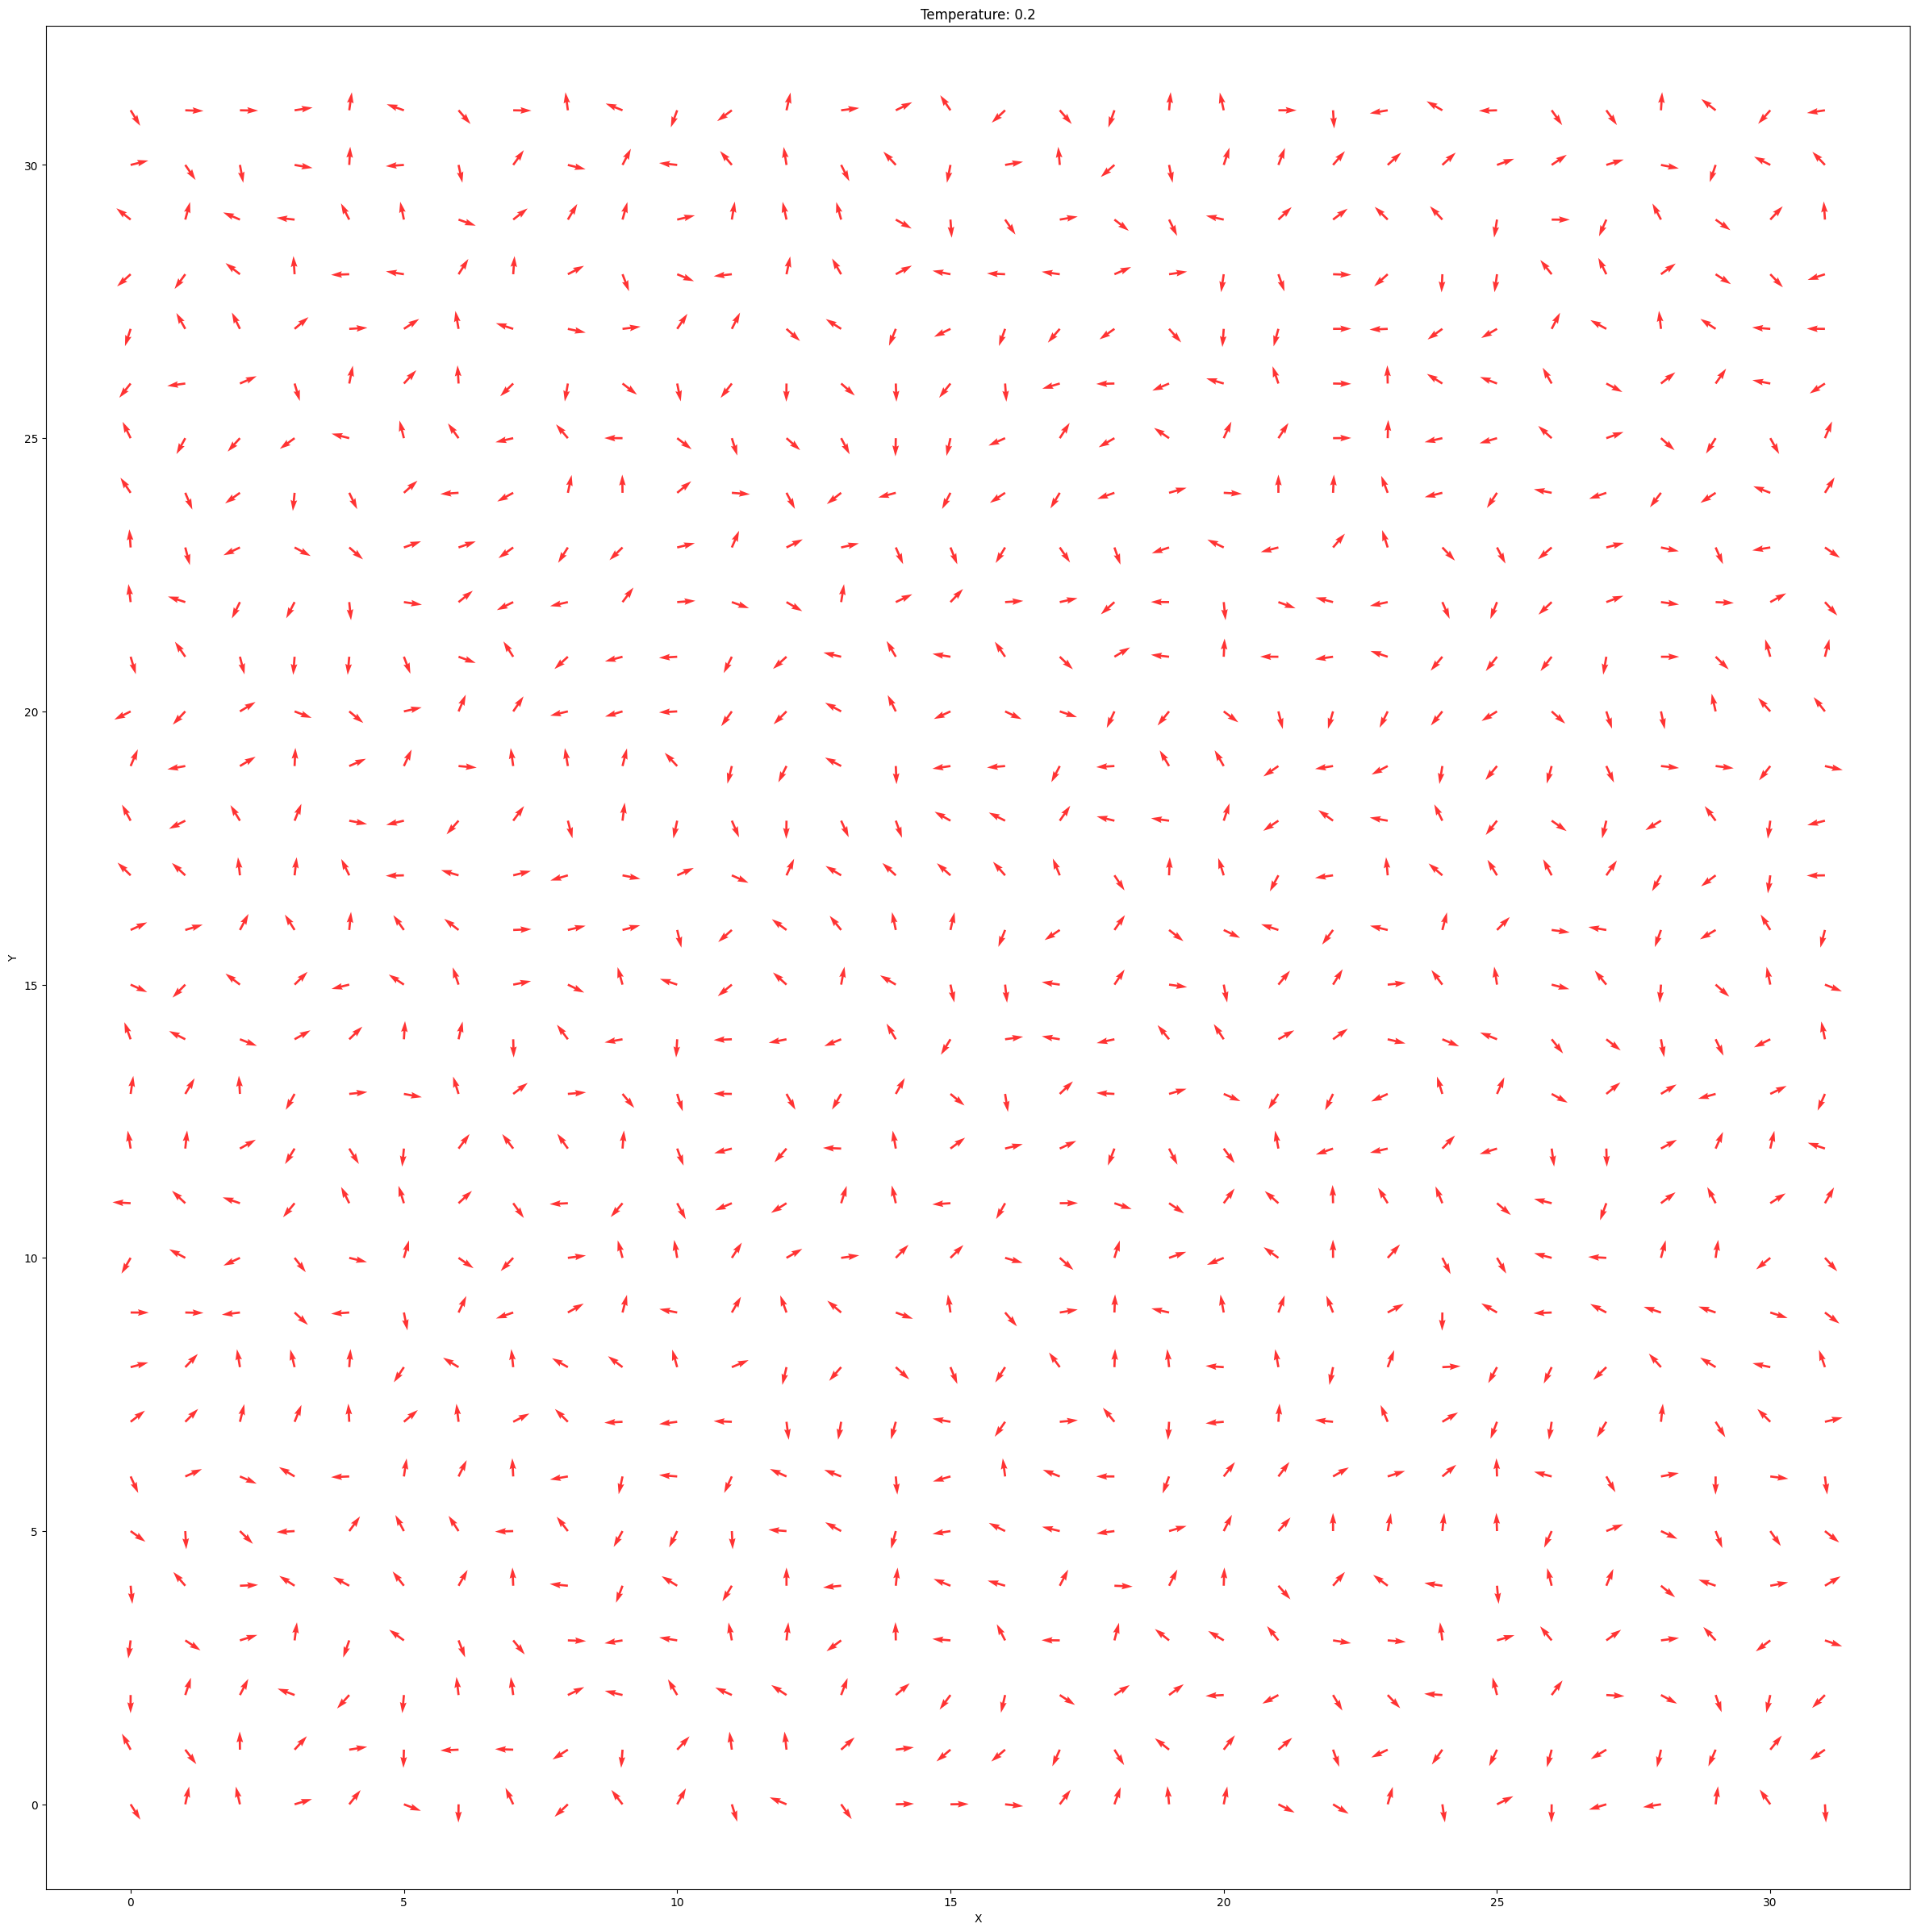

In [49]:
import numpy as np
import matplotlib.pyplot as plt

def visualize_data(data, temperature):
    # Define grid
    x = np.arange(0, 32, 1)
    y = np.arange(0, 32, 1)
    X, Y = np.meshgrid(x, y)

    # Calculate spin directions
    U = np.cos(data)
    V = np.sin(data)

    # Create plot
    fig, ax = plt.subplots(figsize=(30, 30))
    ax.quiver(X, Y, U, V, scale=3, units='xy', width=0.04, color='red', alpha=0.8)  # Adjust scale for larger arrows
    ax.set_aspect('equal', 'box')
    ax.set_title(f"Temperature: {temperature}")
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    plt.show()

# Example usage
visualize_data(img[20000], temperatures[1000])


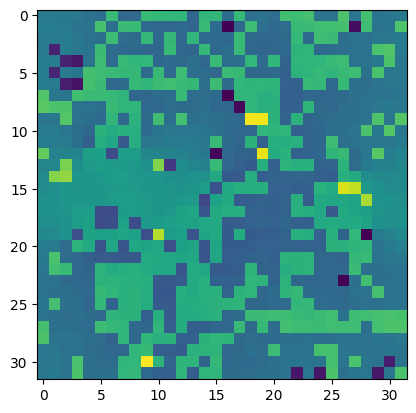

In [14]:
from matplotlib import pyplot as plt
plt.imshow(img[10])

In [ ]:
# import numpy as np
# import matplotlib.pyplot as plt
# from numba import jit

# @jit(nopython=True)
# def calculate_correlation_length(lattice):
#     def _func(x, R, f_log):
#         return R + x[0] * f_log - x[0] * x[1]

#     def least_squares(func, x0, kwargs):
#         return 0.0  # Placeholder for least squares calculation

#     correlations = np.zeros(lattice.shape[0] // 2)
#     for r in range(correlations.shape[0]):
#         rolled = np.roll(lattice, r, axis=0)
#         rolled = np.roll(rolled, r, axis=1)
#         correlations[r] = np.mean(np.cos(2 * np.pi * (lattice - rolled)))
#     bounds = len(correlations) // 5
#     ls = least_squares(_func, [0, 0], kwargs={'R': np.arange(bounds, len(correlations) - bounds),
#                                               'f_log': np.log(np.maximum(correlations[bounds:-bounds], [1e-10] * (len(correlations) - 2 * bounds)))})
#     return 1 / ls

# data = np.load('data_xy32.npz')
# img = data['X']
# temperatures = data['y']

# correlation_lengths = []
# current_temp = temperatures[0]
# correlation_sum = 0
# count = 0

# for lattice, temp in zip(img, temperatures):
#     if temp != current_temp:
#         correlation_lengths.append(correlation_sum / count)
#         correlation_sum = 0
#         count = 0
#         current_temp = temp
#     correlation_sum += calculate_correlation_length(lattice)
#     count += 1

# # Add the correlation length for the last temperature
# correlation_lengths.append(correlation_sum / count)

# # Plotting the scatter plot
# plt.scatter(np.arange(0.1, 3.51, 0.1), correlation_lengths, color='blue', marker='.')
# plt.xlabel('Temperature')
# plt.ylabel('Correlation Length')
# plt.title('Correlation Length vs Temperature')
# plt.grid(True)
# plt.show()


In [71]:
# import numpy as np
# from scipy.optimize import least_squares

# def calculate_correlation_length(lattice):
#     def optimized_func(x, R, f_log):
#         return R + x[0] * f_log - x[0] * x[1]

#     correlations = []
#     for r in range(int(lattice.shape[0] / 2)):
#         rolled = np.roll(lattice, r, axis=0)
#         rolled = np.roll(rolled, r, axis=1)
#         correlations.append(np.mean(np.cos(2 * np.pi * (lattice - rolled))))
#     correlations = np.array(correlations)
#     bounds = int(len(correlations) / 5)
#     ls = least_squares(optimized_func, [0, 0], kwargs={'R' : np.arange(bounds, len(correlations) - bounds),
#                                                        'f_log' : np.log(np.maximum(correlations[bounds:-bounds], [1e-10] * (len(correlations) - 2 * bounds)))})
#     return 1 / ls.x[0]

# # Example usage:
# lattice = img[999]  # Example lattice matrix
# correlation_length = calculate_correlation_length(lattice)
# print("Correlation Length:", correlation_length)


Correlation Length: 4.238286917763834


In [ ]:
# # Initialize lists to store correlation lengths and temperatures
# correlation_lengths = np.zeros(1000)
# base = 30000
# # Iterate over each lattice state
# for i in range(base,base+1000):
#     lattice_state = img[i]
#     correlation_length = calculate_correlation_length(lattice_state)
#     correlation_lengths[i-base] = correlation_length

# # Plotting the correlation length graph
# # plt.scatter(temperatures, correlation_lengths, color='blue', marker='.')
# # plt.xlabel('Temperature')
# # plt.ylabel('Correlation Length')
# # plt.title('Correlation Length vs Temperature')
# # plt.grid(True)
# # plt.show()
# np.sum(correlation_lengths)/1000

In [ ]:
# base = 0, 3074.050229361014
# base = 1000, 3733.657140045942
# base = 2000, 4321.595494700788

# base=20000, corr len = 4276.248452135125
# base=30k, 4228.902782339928

In [66]:
import numpy as np
from scipy.optimize import curve_fit

def correlation_function(lattice_state):
    L = lattice_state.shape[0]  # Size of the lattice
    correlation = np.zeros(L//2)

    for r in range(1, L//2 + 1):
        sum_corr = 0
        count = 0
        for i in range(L):
            for j in range(L):
                neighbor1 = lattice_state[i, j]
                neighbor2 = lattice_state[(i + r) % L, (j + r) % L]
                sum_corr += neighbor1 * neighbor2
                count += 1
        correlation[r-1] = sum_corr / count

    return correlation

def exponential_decay(x, A, xi):
    return A * np.exp(-x / xi)

def calculate_correlation_length(correlation):
    r = np.arange(1, len(correlation) + 1)
    initial_guess = (1.0, 1.0)  # Initial guess for parameters A and xi
    popt, _ = curve_fit(exponential_decay, r, correlation, p0=initial_guess, maxfev=10000)
    return popt[1]

# Example usage
L = 32  # Size of the lattice
lattice_state = img[15999]  # Example lattice state

correlation = correlation_function(lattice_state)
correlation_length = calculate_correlation_length(correlation)

print("Correlation Length:", correlation_length)


Correlation Length: 0.6046212158439649


In [ ]:
# Initialize lists to store correlation lengths and temperatures
correlation_lengths = np.zeros(1000)
corr = np.zeros(35)
k=0
# Iterate over each lattice state
for i in range(len(img)):
    lattice_state = img[i]
    correlation = correlation_function(lattice_state)
    correlation_length = calculate_correlation_length(correlation)
    correlation_lengths[i-k*1000] = correlation_length
    if(i%1000 == 999):
      corr[k]=np.sum(correlation_lengths)/1000
      correlation_lengths = np.zeros(1000)
      k+=1

# Plotting the correlation length graph
plt.scatter(np.arange(0.1,3.51,0.1), corr, color='blue', marker='.')
plt.xlabel('Temperature')
plt.ylabel('Correlation Length')
plt.title('Correlation Length vs Temperature')
plt.grid(True)
plt.show()
np.sum(correlation_lengths)/1000

In [ ]:
class XYDataset(Dataset):
    def __init__(self, file_path):
        self.data = np.load(file_path)
        self.labels = self.data[:, -1]  # Assuming labels are the last column
        self.images = self.data[:, :-1]  # Assuming images are the remaining columns

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        # image = self.images[idx].reshape(1, 20, 20)  # Reshape image to [1, 20, 20]
        image = self.images[idx]
        image = torch.tensor(image, dtype=torch.float32)  # Convert to PyTorch tensor
        label = torch.tensor(int(self.labels[idx]), dtype=torch.int64)  # Convert to PyTorch tensor
        return {'image': image, 'label': label}


In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class BinaryClassificationCNN(nn.Module):
    def __init__(self, Nx, Ny):
        super(BinaryClassificationCNN, self).__init__()
        self.Nx = Nx  # Width of the input matrix
        self.Ny = Ny  # Height of the input matrix

        # Convolutional Layer 1: input channels = 1, output channels = 8, kernel size = 3x3
        self.conv1 = nn.Conv2d(1, 8, kernel_size=3, padding=1)
        # Convolutional Layer 2: input channels = 8, output channels = 16, kernel size = 3x3
        self.conv2 = nn.Conv2d(8, 16, kernel_size=3, padding=1)
        # Max pooling layer reduces size by a factor of 2
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)

        # Calculate the size of the output from the last conv layer after max pooling
        # This is necessary to know how many input features the first fully connected layer expects
        self.final_dim_x = Nx // 2  # Division by 2 due to max pooling
        self.final_dim_y = Ny // 2

        # Fully Connected Layer
        self.fc1 = nn.Linear(16 * self.final_dim_x * self.final_dim_y, 32)
        # Output layer with a single unit for binary classification
        self.output = nn.Linear(32, 1)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = self.pool(x)
        # Flatten the output for the fully connected layer
        x = x.view(-1, 16 * self.final_dim_x * self.final_dim_y)
        x = F.relu(self.fc1(x))
        x = torch.sigmoid(self.output(x))
        return x

# Assuming the input batch of matrices has a shape of [batch_size, 1, Nx, Ny]
# For demonstration, let's create a random tensor with this shape
batch_size = 4  # Example batch size
Nx, Ny = 40, 40  # Example dimensions of the input matrices
input_matrices = torch.randn(batch_size, 1, Nx, Ny)

# Create an instance of the model and pass the input batch through it
model = BinaryClassificationCNN(Nx, Ny)
output = model(input_matrices)

# Print the output shape to verify
print(output.shape)  # Should be [batch_size, 1], each indicating the prediction for a matrix

#### Attention

In [ ]:
class SpatialAttentionModule(nn.Module):
    def __init__(self, in_channels):
        super(SpatialAttentionModule, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, 1, kernel_size=3, padding=1)  # Adjusted kernel size for 20x20 lattice
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        max_out, _ = torch.max(x, dim=1, keepdim=True)
        avg_out = torch.mean(x, dim=1, keepdim=True)
        out = torch.cat([max_out, avg_out], dim=1)
        out = self.conv1(out)
        return self.sigmoid(out)


In [ ]:
class BKT_CNN(nn.Module):
    def __init__(self):
        super(BKT_CNN, self).__init__()
        # Feature extraction layers
        self.features = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        # Attention module
        self.attention = SpatialAttentionModule(in_channels=64)  # Adjusted input channels
        # Classification layers
        self.fc1 = nn.Linear(64 * 5 * 5, 128)  # Adjusted input size for 20x20 lattice
        self.fc2 = nn.Linear(128, 2)  # 2 output classes for the two phases


    def forward(self, x):
        # Feature extraction
        x = self.features(x)
        # Attention mechanism
        attention = self.attention(x)
        x = x * attention
        # Flatten for fully connected layers
        x = x.view(x.size(0), -1)
        # Classification layers
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return F.softmax(x, dim=1)  # Output probability distribution over the phases


In [ ]:
dataset[0]

{'image': tensor([0.0100, 0.0010]), 'label': tensor(49)}

In [ ]:
# Define your dataset and dataloader
dataset = XYDataset('data.npy')
dataloader = DataLoader(dataset, batch_size=32, shuffle=True)

# Instantiate the model
model = BKT_CNN()

# Move model to CUDA device if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Define your loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)

In [ ]:
def train_model(model, dataloader, criterion, optimizer, num_epochs=10, print_every=100):
    model.train()
    device = next(model.parameters()).device  # Get the device from the model's parameters
    for epoch in range(num_epochs):
        running_loss = 0.0
        for i, batch in enumerate(dataloader):
            inputs, labels = batch['image'].to(device), batch['label'].to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
            if (i + 1) % print_every == 0:
                print(f'Epoch [{epoch + 1}/{num_epochs}], Step [{i + 1}/{len(dataloader)}], Loss: {running_loss / print_every:.4f}')
                running_loss = 0.0


In [ ]:
# Train the model
train_model(model, dataloader, criterion, optimizer, num_epochs=10, print_every=100)

ValueError: cannot reshape array of size 2 into shape (1,20,20)